#  Курсовой проект по курсу "Рекомендательные системы"

**Основное**
- Целевая метрика precision@5
- Бейзлайн решения - [MainRecommender](https://github.com/geangohn/recsys-tutorial/blob/master/src/recommenders.py)
- Сдаем ссылку на github с решением. На github должен быть файл recommendations.csv (user_id | [rec_1, rec_2, ...] с рекомендациями. rec_i - реальные id item-ов (из retail_train.csv)

---

In [295]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [296]:
!pip install implicit==0.4.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Загрузка библиотек

In [297]:
# загружаем вспомогательные модули
!cp /content/drive/MyDrive/Colab_Notebooks/21_рекомендательные_системы/best_lib/metrics.py .
!cp /content/drive/MyDrive/Colab_Notebooks/21_рекомендательные_системы/best_lib/recommenders.py .
!cp /content/drive/MyDrive/Colab_Notebooks/21_рекомендательные_системы/best_lib/utils.py .

In [298]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix


# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Модель второго уровня
from lightgbm import LGBMClassifier

# # LightFM
# from lightfm import LightFM
# from lightfm.evaluation import precision_at_k, recall_at_k

# Libraries for working with paths and saving
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# from src.metrics import precision_at_k as custom_precision, recall_at_k
# from src.metrics import precision_at_k, recall_at_k
# from src.utils import prefilter_items
# from src.recommenders import MainRecommender

# Рукописные модули
import metrics
import recommenders
import utils

from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

## Функции

In [299]:
def get_rec_eval_model(model, X_train_orig, df_actual_orig, top_n, rec=False, score=False,
                        USER_COL='user_id', ACTUAL_COL='actual', k=5):
    # копируем сеты
    X_train = X_train_orig.copy()
    df_actual = df_actual_orig.copy()
    # ищем общих пользователей
    common_users = set(set(df_actual[USER_COL]) & set(X_train[USER_COL]))
    # предсказываем вероятность для пар пользователь-товар
    X_train['prob'] = model.predict_proba(X_train)[:,1]
    # берём первые TOPK_PRECISION самых вероятных товаров для каждого пользователя
    df_actual['Predicted'] = df_actual[USER_COL].apply(lambda user_id: 
            X_train[X_train[USER_COL]==user_id].sort_values('prob', 
                                        ascending=False).head(k).item_id.tolist() if user_id in common_users else top_n[:k])
    if score or not rec:
        # precision_at_k
        res = df_actual.apply(lambda row: precision_at_k(row['Predicted'], row[ACTUAL_COL], k=k), axis=1).mean()
    
    if not rec and score:
        return res
    
    if rec and not score:
        return df_actual
    
    return {'Predicted': df_actual, 'score': res}

## Чтение данных

In [300]:
PATH_DATA = "/content/drive/MyDrive/Colab_Notebooks/21_рекомендательные_системы/data"

In [301]:
data = pd.read_csv(os.path.join(PATH_DATA,'retail_train.csv'))
item_features = pd.read_csv(os.path.join(PATH_DATA,'product.csv'))
user_features = pd.read_csv(os.path.join(PATH_DATA,'hh_demographic.csv'))

## Process features dataset

### Variables used

In [302]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'
ACTUAL_COL = 'actual'
RANDOM_STATE = 42

In [303]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

## Split dataset for train, eval, test

In [304]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)


VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [305]:
# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

# сделаем объединенный сет данных для первого уровня (матчинга)
df_join_train_matcher = pd.concat([data_train_matcher, data_val_matcher])

In [306]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [307]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2108779, 12) Users: 2498 Items: 83685
val_matcher
Shape: (169711, 12) Users: 2154 Items: 27649
train_ranker
Shape: (169711, 12) Users: 2154 Items: 27649
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329


In [308]:
# выше видим разброс по пользователям и товарам

In [309]:
data_val_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0


## Prefilter items

In [310]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=1000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 1001


## Make cold-start to warm-start

In [311]:
# ищем общих пользователей
common_users = list(set(data_train_matcher.user_id.values)&(set(data_val_matcher.user_id.values))&set(data_val_ranker.user_id.values))

data_train_matcher = data_train_matcher[data_train_matcher.user_id.isin(common_users)]
data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (422570, 13) Users: 1908 Items: 1001
val_matcher
Shape: (162896, 12) Users: 1908 Items: 27106
train_ranker
Shape: (162896, 12) Users: 1908 Items: 27106
val_ranker
Shape: (115735, 12) Users: 1908 Items: 24030


## Init/train recommender

In [312]:
recommender = MainRecommender(data_train_matcher)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

### Варианты, как получить кандидатов

Можно потом все эти варианты соединить в один

(!) Если модель рекомендует < N товаров, то рекомендации дополняются топ-популярными товарами до N

In [313]:
# Берем тестового юзера 2375

In [314]:
recommender.get_als_recommendations(2375, N=5)

[1044078, 844179, 899624, 880150, 823990]

In [315]:
recommender.get_own_recommendations(2375, N=5)

[1085983, 999104, 835300, 947858, 989069]

In [316]:
recommender.get_similar_items_recommendation(2375, N=5)

[9553397, 844179, 1068292, 1025535, 8065410]

In [317]:
recommender.get_similar_users_recommendation(2375, N=5)

[9553042, 9575582, 861494, 1108168, 863885]

## Eval recall of matching

- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

In [318]:
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,6,"[1024306, 1102949, 6548453, 835394, 940804, 96..."


In [319]:
# N = Neighbors
N_PREDICT = 50 

In [320]:
%%time
result_eval_matcher['own_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
result_eval_matcher['sim_item_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_items_recommendation(x, N=N_PREDICT))
result_eval_matcher['als_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=N_PREDICT))

CPU times: user 15 s, sys: 14.5 s, total: 29.5 s
Wall time: 28.4 s


#### Пускай, если юзер купил < 50 товаров, то get_own_recommendations дополнит рекоммендации топ-популярными

In [321]:
result_eval_matcher.head(8)

,user_id,actual,own_rec,sim_item_rec,als_rec
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 5577022, 8090541, 1104349, 940947, 10...","[1045586, 5582712, 891961, 8090532, 1075214, 1...","[871756, 859191, 1022097, 856942, 8090541, 110..."
1,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[5569792, 1048257, 863447, 1084036, 1098844, 1...","[948650, 5569845, 1127831, 863447, 930118, 871...","[871611, 930118, 863447, 948650, 1098844, 8668..."
2,7,"[836281, 843306, 845294, 914190, 920456, 93886...","[1122358, 1128333, 5590695, 6602729, 862682, 9...","[1019247, 5981267, 12731436, 928342, 1021116, ...","[5572738, 1122358, 1013928, 12810393, 863762, ..."
3,8,"[868075, 886787, 945611, 1005186, 1008787, 101...","[10282046, 935393, 7139529, 982790, 981086, 97...","[1044078, 5569845, 1042438, 8177622, 835530, 8...","[902172, 6633273, 948953, 5570383, 12301109, 5..."
4,9,"[883616, 1029743, 1039126, 1051323, 1082772, 1...","[949294, 8019977, 6534030, 882190, 862799, 871...","[8090537, 6514160, 6533362, 5569845, 1022097, ...","[862799, 949294, 8090532, 5569471, 882190, 887..."
5,13,"[6544236, 822407, 908317, 1056775, 1066289, 11...","[965772, 1042942, 898466, 1038985, 882604, 107...","[999999, 1067695, 857503, 906838, 1089954, 104...","[1029743, 5591170, 5568447, 5569374, 1075214, ..."
6,14,"[917277, 981760, 878234, 925514, 986394, 10220...","[1123106, 1013928, 910673, 1009187, 1007210, 1...","[999999, 1025611, 985999, 863762, 866755, 8279...","[962185, 965766, 1106523, 5568378, 1044078, 85..."
7,15,"[996016, 1014509, 1044404, 1087353, 976199, 10...","[1026118, 1051516, 1088414, 933637, 1122358, 8...","[1022097, 999999, 963868, 999250, 1127831, 101...","[1082185, 1026118, 933637, 1098248, 1098844, 8..."


In [322]:
def calc_recall(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [323]:
def calc_precision(df_data, top_k):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

### Recall@50 of matching

In [324]:
TOPK_RECALL = 50

In [325]:
sorted(calc_recall(result_eval_matcher, TOPK_RECALL), key=lambda x: x[1],reverse=True)

[('own_rec', 0.05745308995956129),
 ('als_rec', 0.04320965574365568),
 ('sim_item_rec', 0.03764182011397419)]

### Precision@5 of matching

In [326]:
TOPK_PRECISION = 5

In [327]:
sorted(calc_precision(result_eval_matcher, TOPK_PRECISION), key=lambda x: x[1],reverse=True)

[('own_rec', 0.15922431865828093),
 ('als_rec', 0.09958071278825996),
 ('sim_item_rec', 0.06635220125786163)]

In [328]:
%%time

K = [100, 200, 350, 500]

als_rec_at_k  = [(result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=k)), k) for k in K]

als_recall_at_k = [(np.array([recall_at_k(rec[0][i], result_eval_matcher[ACTUAL_COL][i], k=rec[1]) for i in result_eval_matcher.index]).mean(), rec[1]) for rec in als_rec_at_k]

als_recall_at_k

CPU times: user 25.3 s, sys: 20.6 s, total: 45.9 s
Wall time: 23.9 s


[(0.06264744305208393, 100),
 (0.08773137942485137, 200),
 (0.111204813555215, 350),
 (0.12894583516274424, 500)]

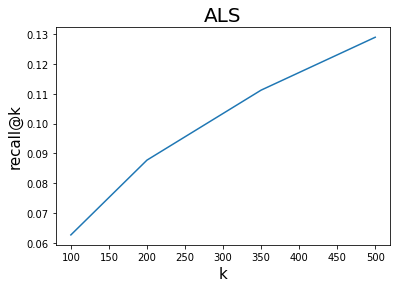

In [329]:
plt.plot(K, list(map(lambda x: x[0], als_recall_at_k)))
plt.title('ALS', fontsize=20)
plt.xlabel('k', fontsize=15)
plt.ylabel('recall@k', fontsize=15)
plt.show()

C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?  

Чем больше k, чем больше потенциальных товаров (кандидатов) мы отбираем, тем модель второго уровня порекомендует точнее, но это будет дольше, так как количеcтво данных возрастёт до n * k, где n, это количетсво пользователей для которых мы рекомендуем, с учётом горячего старта 1908 пользователей.

Число k подбирается с учётом возможностей по мощности и времени ожидания.

Оптимальное число k находится на перегибе графика recall@k(k), там где стремительный рост recall@k снижается. В нашем случае за перегиб можно взять точку k=200.

In [330]:
N_PREDICT = 350

### Top-n items

Найдём топ товаров для каждого этапа, чтобы рекомендовать их новым пользователям

In [331]:
def get_top_n(data, ITEM_COL='item_id', USER_COL='user_id', QUANTITY_COL='quantity', N=5):
        res = data.groupby(ITEM_COL)[QUANTITY_COL].count().reset_index()
        res.sort_values(QUANTITY_COL, ascending=False, inplace=True)
        res = res.item_id.head(N).tolist()
        return res

In [332]:
top_n_train_matcher = get_top_n(data_train_matcher, 
                                ITEM_COL=ITEM_COL, USER_COL=USER_COL, QUANTITY_COL='quantity', N=N_PREDICT)
top_n_train = get_top_n(df_join_train_matcher, ITEM_COL=ITEM_COL, USER_COL=USER_COL,  QUANTITY_COL='quantity', N=N_PREDICT)
top_n_train_matcher[:5]

[999999, 1029743, 1106523, 5569230, 916122]

## Ranking part

### Обучаем модель 2-ого уровня на выбранных кандидатах

## Подготовка данных для трейна

In [333]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [334]:
# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

In [335]:
df_match_candidates.head(3)

,user_id,candidates
0,2070,"[1031316, 911017, 8015407, 913210, 954966, 941..."
1,2021,"[1119454, 1013928, 6534077, 1065538, 835578, 8..."
2,1753,"[6979579, 1067695, 1028891, 1053754, 7441210, ..."


In [336]:
# разворачиваем товары
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = ITEM_COL

In [337]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [338]:
df_match_candidates.head(4)

,user_id,item_id
0,2070,1031316
0,2070,911017
0,2070,8015407
0,2070,913210


### Check warm start

In [339]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (667800, 2) Users: 1908 Items: 999


### Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1 

In [340]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

#### Не хватает нулей в датасете, поэтому добавляем наших кандитатов в качество нулей

In [341]:
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

# чистим дубликаты
df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])

df_ranker_train['target'].fillna(0, inplace= True)

In [342]:
df_ranker_train.target.value_counts()

0.0    606764
1.0     15922
Name: target, dtype: int64

In [343]:
df_ranker_train.head(2)

,user_id,item_id,target
0,2070,1031316,0.0
1,2070,911017,0.0


In [344]:
df_ranker_train['target'].mean()

0.025569869886266916

## Подготавливаем фичи для обучения модели

**Фичи user_id:**
    - Средний чек
    - Средняя сумма покупки 1 товара в каждой категории
    - Кол-во покупок в каждой категории
    - Частотность покупок раз/месяц
    - Долю покупок в выходные
    - Долю покупок утром/днем/вечером

**Фичи item_id**:
    - Кол-во покупок в неделю
    - Среднее кол-во покупок 1 товара в категории в неделю
    - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
    - Цена (Можно посчитать из retil_train.csv)
    - Цена / Средняя цена товара в категории
    
**Фичи пары user_id - item_id**
    - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
    - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

### Описательные фичи

In [345]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [346]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [347]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1031316,0.0,539,DRUG GM,National,CIGARETTES,CIGARETTES,974048 PK,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,911017,0.0,539,DRUG GM,National,CIGARETTES,CIGARETTES,912352 PK,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


### Поведенческие фичи

##### Чтобы считать поведенческие фичи, нужно учесть все данные что были до data_val_ranker

### user

In [348]:
# user_features.head(2)

In [349]:
df_ranker_train[~df_ranker_train['user_id'].isin(user_features.user_id)].shape[0]

380525

In [350]:
df_ranker_train['user_id'].shape[0]

622686

In [351]:
df_ranker_train[~df_ranker_train['user_id'].isin(user_features.user_id)].shape[0] / df_ranker_train['user_id'].shape[0] * 100

61.11025460665568

Отсутствуют данные о 60% пользователей, по этому мы не будем использовать user_features который нам дан, но сделаем небольшой свой на основе имеющихся данных из data.

Средний чек

In [352]:
average_check = (data_train_ranker.groupby([USER_COL])['sales_value'].sum() 
                                  / data_train_ranker.groupby([USER_COL])['basket_id'].nunique()).reset_index()

average_check.columns=[USER_COL, 'average_check']

user_features = average_check.copy()

Количество покупок в месяц

In [353]:
user_per_month = (data_train_ranker.groupby([USER_COL])['basket_id'].nunique() 
                                                  / ((VAL_MATCHER_WEEKS*7) / (365/12))).reset_index()

user_per_month.columns=[USER_COL, 'user_per_month']

user_features = user_features.merge(user_per_month, on=USER_COL, how='left')

In [354]:
user_features.head(2)

,user_id,average_check,user_per_month
0,1,48.825714,5.069444
1,6,20.562500,11.587302


### item

In [355]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


Количество покупок в неделю

In [356]:
item_per_week = (data_train_ranker.groupby([ITEM_COL])['quantity'].sum() / 6).reset_index()

item_per_week.columns=[ITEM_COL, 'item_per_week']

item_features = item_features.merge(item_per_week, on=ITEM_COL, how='left')

item_features.item_per_week.fillna(0, inplace=True)

Цена

In [357]:
data_price = data[data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS)] 

data_price['price'] = data_price['sales_value'] / data_price['quantity']

price = (data_price.groupby([ITEM_COL])['price'].first()).reset_index()

item_features = item_features.merge(price, on=ITEM_COL, how='left')

<ipython-input-357-4a0e449c924e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_price['price'] = data_price['sales_value'] / data_price['quantity']


In [358]:
item_features.price.fillna(item_features.price.median(), inplace=True)

In [359]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,item_per_week,price
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,0.0,3.49
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,0.0,0.99


### user-item

In [360]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

In [361]:
df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg('sales_value').sum().rename('total_item_sales_value'), how='left',on=ITEM_COL)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg('quantity').sum().rename('total_quantity_value'), how='left',on=ITEM_COL)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg(USER_COL).count().rename('item_freq'), how='left',on=ITEM_COL)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg(USER_COL).count().rename('user_freq'), how='left',on=USER_COL)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg('sales_value').sum().rename('total_user_sales_value'), how='left',on=USER_COL)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg('quantity').sum().rename('item_quantity_per_week')/df_join_train_matcher.week_no.nunique(), how='left',on=ITEM_COL)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg('quantity').sum().rename('user_quantity_per_week')/df_join_train_matcher.week_no.nunique(), how='left',on=USER_COL)


df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg('quantity').sum().rename('item_quantity_per_basket')/df_join_train_matcher.basket_id.nunique(), how='left',on=ITEM_COL)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg('quantity').sum().rename('user_quantity_per_baskter')/df_join_train_matcher.basket_id.nunique(), how='left',on=USER_COL)


df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=ITEM_COL).agg(USER_COL).count().rename('item_freq_per_basket')/df_join_train_matcher.basket_id.nunique(), how='left',on=ITEM_COL)

df_ranker_train = df_ranker_train.merge(df_join_train_matcher.groupby(by=USER_COL).agg(USER_COL).count().rename('user_freq_per_basket')/df_join_train_matcher.basket_id.nunique(), how='left',on=USER_COL)


In [362]:
df_ranker_train.head(3)

,user_id,item_id,target,manufacturer_x,department_x,brand_x,commodity_desc_x,sub_commodity_desc_x,curr_size_of_product_x,age_desc,...,total_quantity_value,item_freq,user_freq,total_user_sales_value,item_quantity_per_week,user_quantity_per_week,item_quantity_per_basket,user_quantity_per_baskter,item_freq_per_basket,user_freq_per_basket
0,2070,1031316,0.0,539,DRUG GM,National,CIGARETTES,CIGARETTES,974048 PK,45-54,...,291,195,1996,5754.86,3.197802,1218.32967,0.001187,0.452137,0.000795,0.00814
1,2070,911017,0.0,539,DRUG GM,National,CIGARETTES,CIGARETTES,912352 PK,45-54,...,122,105,1996,5754.86,1.340659,1218.32967,0.000498,0.452137,0.000428,0.00814
2,2070,8015407,0.0,1216,DELI,National,SANDWICHES,SANDWICHES - (COLD),,45-54,...,214,138,1996,5754.86,2.351648,1218.32967,0.000873,0.452137,0.000563,0.00814


In [363]:
df_ranker_train.isna().sum().sum()

2663675

Пропусков нет

In [364]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [365]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer_x',
 'department_x',
 'brand_x',
 'commodity_desc_x',
 'sub_commodity_desc_x',
 'curr_size_of_product_x',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'manufacturer_y',
 'department_y',
 'brand_y',
 'commodity_desc_y',
 'sub_commodity_desc_y',
 'curr_size_of_product_y',
 'item_per_week',
 'price',
 'average_check',
 'user_per_month',
 'total_item_sales_value',
 'total_quantity_value',
 'item_freq',
 'user_freq',
 'total_user_sales_value',
 'item_quantity_per_week',
 'user_quantity_per_week',
 'item_quantity_per_basket',
 'user_quantity_per_baskter',
 'item_freq_per_basket',
 'user_freq_per_basket']

## Обучение модели ранжирования

In [366]:
result_val = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_val.columns=[USER_COL, ACTUAL_COL]
result_val.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."


In [367]:
lgb = LGBMClassifier(objective='binary',
                     max_depth=10,
                     n_estimators=1000,
                     learning_rate=0.1,
                     categorical_column=cat_feats,
                     seed=RANDOM_STATE)

lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


In [368]:
df_ranker_predict = df_ranker_train.copy()

In [369]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [370]:
df_ranker_predict.head()

,user_id,item_id,target,manufacturer_x,department_x,brand_x,commodity_desc_x,sub_commodity_desc_x,curr_size_of_product_x,age_desc,...,item_freq,user_freq,total_user_sales_value,item_quantity_per_week,user_quantity_per_week,item_quantity_per_basket,user_quantity_per_baskter,item_freq_per_basket,user_freq_per_basket,proba_item_purchase
0,2070,1031316,0.0,539,DRUG GM,National,CIGARETTES,CIGARETTES,974048 PK,45-54,...,195,1996,5754.86,3.197802,1218.32967,0.001187,0.452137,0.000795,0.00814,0.006883
1,2070,911017,0.0,539,DRUG GM,National,CIGARETTES,CIGARETTES,912352 PK,45-54,...,105,1996,5754.86,1.340659,1218.32967,0.000498,0.452137,0.000428,0.00814,0.004533
2,2070,8015407,0.0,1216,DELI,National,SANDWICHES,SANDWICHES - (COLD),,45-54,...,138,1996,5754.86,2.351648,1218.32967,0.000873,0.452137,0.000563,0.00814,0.004511
3,2070,913210,1.0,2,GROCERY,National,WATER - CARBONATED/FLVRD DRINK,NON-CRBNTD DRNKING/MNERAL WATE,405.6 OZ,45-54,...,1175,1996,5754.86,14.989011,1218.32967,0.005563,0.452137,0.004792,0.00814,0.665175
4,2070,954966,0.0,693,DRUG GM,National,CANDY - PACKAGED,CANDY BARS (MULTI PACK),6 PK,45-54,...,326,1996,5754.86,5.263736,1218.32967,0.001953,0.452137,0.001329,0.00814,0.000149


In [371]:
df_ranker_predict.shape

(622686, 38)

In [372]:
df_ranker_predict.loc[df_ranker_predict[USER_COL]==2070].sort_values('proba_item_purchase', ascending=False)

,user_id,item_id,target,manufacturer_x,department_x,brand_x,commodity_desc_x,sub_commodity_desc_x,curr_size_of_product_x,age_desc,...,item_freq,user_freq,total_user_sales_value,item_quantity_per_week,user_quantity_per_week,item_quantity_per_basket,user_quantity_per_baskter,item_freq_per_basket,user_freq_per_basket,proba_item_purchase
177,2070,1082185,1.0,2,PRODUCE,National,TROPICAL FRUIT,BANANAS,40 LB,45-54,...,26127,1996,5754.86,297.846154,1218.32967,0.110534,0.452137,0.106550,0.00814,0.809511
250,2070,12301839,1.0,4020,MEAT,National,BEEF,PRIMAL,,45-54,...,392,1996,5754.86,5.087912,1218.32967,0.001888,0.452137,0.001599,0.00814,0.750160
34,2070,899624,1.0,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),10 LB,45-54,...,2111,1996,5754.86,23.791209,1218.32967,0.008829,0.452137,0.008609,0.00814,0.737736
26,2070,838186,1.0,1790,GROCERY,National,BAKED SWEET GOODS,SW GDS:DONUTS,18.2 OZ,45-54,...,694,1996,5754.86,8.263736,1218.32967,0.003067,0.452137,0.002830,0.00814,0.726072
261,2070,827656,1.0,4208,DELI,National,DELI MEATS,MEAT:HAM BULK,,45-54,...,399,1996,5754.86,4.505495,1218.32967,0.001672,0.452137,0.001627,0.00814,0.722862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,2070,1041031,0.0,3037,MEAT,National,PORK,ENHANCED,,45-54,...,185,1996,5754.86,2.175824,1218.32967,0.000807,0.452137,0.000754,0.00814,0.000019
318,2070,890739,0.0,3035,MEAT,National,PORK,ENHANCED,,45-54,...,176,1996,5754.86,2.153846,1218.32967,0.000799,0.452137,0.000718,0.00814,0.000019
229,2070,996070,0.0,673,PRODUCE,National,APPLES,APPLES GALA (BULK&BAG),3 LB,45-54,...,412,1996,5754.86,4.923077,1218.32967,0.001827,0.452137,0.001680,0.00814,0.000017
10,2070,865174,0.0,673,PRODUCE,National,APPLES,APPLES GRANNY SMITH (BULK&BAG),3 LB,45-54,...,460,1996,5754.86,5.043956,1218.32967,0.001872,0.452137,0.001876,0.00814,0.000016


## Подведем итоги

    Мы обучили модель ранжирования на покупках из сета data_train_ranker и на кандитатах от own_recommendations, что является тренировочным сетом, и теперь наша задача предсказать и оценить именно на тестовом сете.

# Evaluation on test dataset

In [373]:
result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."


## Eval matching on test dataset

In [374]:
%%time
result_eval_ranker['own_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

CPU times: user 1.68 s, sys: 28.9 ms, total: 1.7 s
Wall time: 1.71 s


In [375]:
# померяем precision только модели матчинга, чтобы понимать влияение ранжирования на метрики

sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('own_rec', 0.13259958071278827)]

## Eval re-ranked matched result on test dataset
    Вспомним df_match_candidates сет, который был получен own_recommendations на юзерах, набор пользователей мы фиксировали и он одинаков, значит и прогноз одинаков, поэтому мы можем использовать этот датафрейм для переранжирования.
    

In [376]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [377]:
result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [378]:
result_eval_ranker.head()

,user_id,actual,own_rec,reranked_own_rec
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[856942, 5577022, 8090541, 1104349, 940947, 10...","[1082185, 856942, 940947, 1115576, 1082212]"
1,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[5569792, 1048257, 863447, 1084036, 1098844, 1...","[5570882, 850102, 878996, 12301109, 1024306]"
2,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1122358, 1128333, 5590695, 6602729, 862682, 9...","[991223, 1082185, 993638, 1122358, 1106523]"
3,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[10282046, 935393, 7139529, 982790, 981086, 97...","[1082185, 12302069, 12301839, 1029743, 1074754]"
4,9,"[864335, 990865, 1029743, 9297474, 10457112, 8...","[949294, 8019977, 6534030, 882190, 862799, 871...","[1082185, 1051323, 937292, 857503, 1029743]"


In [379]:
print(*sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.22117400419287211)
('own_rec', 0.13259958071278827)


# Оценка на тесте для выполнения курсового проекта

In [380]:
df_test = pd.read_csv(os.path.join(PATH_DATA,'retail_test1.csv'))

In [381]:
df_test.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,1340,41652823310,664,912987,1,8.49,446,0.0,52,96,0.0,0.0
1,588,41652838477,664,1024426,1,6.29,388,0.0,8,96,0.0,0.0
2,2070,41652857291,664,995242,5,9.10,311,-0.6,46,96,0.0,0.0
3,1602,41665647035,664,827939,1,7.99,334,0.0,1741,96,0.0,0.0
4,1602,41665647035,664,927712,1,0.59,334,-0.4,1741,96,0.0,0.0


In [382]:
result_test = df_test.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_test.columns=[USER_COL, ACTUAL_COL]
result_test.head(2)

,user_id,actual
0,1,"[880007, 883616, 931136, 938004, 940947, 94726..."
1,2,"[820165, 820291, 826784, 826835, 829009, 85784..."


In [383]:
rec = get_rec_eval_model(lgb, X_train, result_test[[USER_COL]], top_n_train, rec=True, 
                                USER_COL=USER_COL, ACTUAL_COL=ACTUAL_COL, k=TOPK_PRECISION)
rec.head()

,user_id,Predicted
0,1,"[1082185, 856942, 940947, 1115576, 1082212]"
1,2,"[1082185, 6534178, 1029743, 995242, 1106523]"
2,3,"[1082185, 6534178, 1029743, 995242, 1106523]"
3,6,"[5570882, 850102, 878996, 12301109, 1024306]"
4,7,"[991223, 1082185, 993638, 1122358, 1106523]"


In [385]:
rec.to_csv('recommendations.csv', index=False)